# JungHyun Bang
# 220544997/1




Title : predicting protein solubility 

data set used: eSOL: Solubility data for Ecoli proteins


In [32]:
import pandas as pd
import requests
import json
import time

In [ ]:
d1 =pd.read_csv("esol.csv")
print(d1.columns)

Index(['JW_ID', 'ECK number', 'B number', 'Gene name K-12', 'Locus name K-12',
       'Synonyms of locus names K-12', 'Solubility (%)', 'Yield (uM)',
       'Yield (ug/ml)', 'Minus Sol (%)', 'TF Sol (%)', 'GroE Sol (%)',
       'KJE Sol (%)', 'Minus Yield (uM)', 'TF Yield (uM)', 'GroE Yield (uM)',
       'KJE Yield (uM)', 'Minus Yield (ug/ml)', 'TF Yield (ug/ml)',
       'GroE Yield (ug/ml)', 'KJE Yield (ug/ml)', 'Calculated MW (kDa)',
       'Calculated pI', 'Type of gene product', 'Gene product description',
       'Cell location', 'Structure (PDB) ID', 'SCOP assignment'],
      dtype='object')


Okay first things first lets try and identify the dimensions that confer with solubility.

Deffo Solubility (%) will be our lable, so this needs to be non-NAN 
"Calculated MW (kDa)", "Calculated pI" these are features that will have direct impact on the solubility i think. We should use this.

biologically speeking, Yeild data('Yield (uM)','Yield (ug/ml)') will have some correlation with solubility but this may result in high correlation issues.

'Type of gene product', 'Cell location' These features may have some critical instance class bias as some classes of proteins may be less expressable(less soluble)  lets keep this for future use.

In [10]:
cols = ["Solubility (%)", "Calculated MW (kDa)", "Calculated pI", "Yield (uM)", "Yield (ug/ml)", "Type of gene product", "Cell location"]
crit_col = ["Solubility (%)", "Calculated MW (kDa)", "Calculated pI"]
print(f"n Tot insatnce: {len(d1)}")

print("n NAN per col ")
print(d1[cols].isna().sum())
print()

print("% of NAN per col")
print(d1[cols].isna().mean())
print()


print("instances with complete data for critical columns")
mask_valid = d1[crit_col].notna().all(axis=1)
print(f"n Logical test ok instances:  {mask_valid.sum()}")
print(f"% Logical test ok instances: {mask_valid.mean()}")


n Tot insatnce: 4132
n NAN per col 
Solubility (%)          959
Calculated MW (kDa)       0
Calculated pI             0
Yield (uM)              959
Yield (ug/ml)           959
Type of gene product      0
Cell location             2
dtype: int64

% of NAN per col
Solubility (%)          0.232091
Calculated MW (kDa)     0.000000
Calculated pI           0.000000
Yield (uM)              0.232091
Yield (ug/ml)           0.232091
Type of gene product    0.000000
Cell location           0.000484
dtype: float64

instances with complete data for critical columns
n Logical test ok instances:  3173
% Logical test ok instances: 0.7679090029041626


Okay i think we can proceed with this.
Now for better model development, we need more features. From UNIPROT, we will be able to get these information....
need some data crawling.

first we will clean the data and append the sequence column.

In [ ]:
d1 = pd.read_csv("esol.csv")

optional_cols = ["Yield (uM)", "Yield (ug/ml)", "Type of gene product", "Cell location"]


# first we need the lable.. so 
cdf = d1.dropna(subset=["Solubility (%)"]).copy()
print("Clean shape:", cdf.shape)
print(cdf[crit_col].isna().sum())


Clean shape: (3173, 28)
Solubility (%)         0
Calculated MW (kDa)    0
Calculated pI          0
dtype: int64


okay, no need for further cleaning. 

array([[<Axes: title={'center': 'Solubility (%)'}>,
        <Axes: title={'center': 'Calculated MW (kDa)'}>],
       [<Axes: title={'center': 'Calculated pI'}>, <Axes: >]],
      dtype=object)

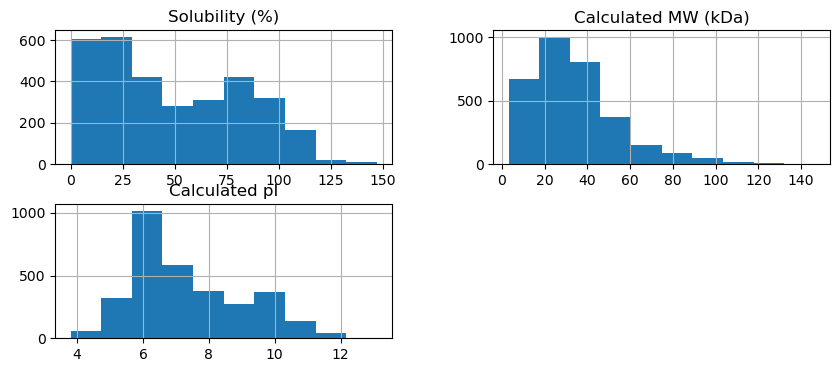

In [16]:
cdf_woptional = cdf[optional_cols].copy()
#storing the additioanl dimensions just incase for further evaluation.

#inspecting the feature distribution.
cdf.describe()
cdf[crit_col].hist(figsize=(10, 4))

Nice, nothing seems unusual. Lets now get the sequence data.

In [18]:
print(cdf.head)

<bound method NDFrame.head of        JW_ID ECK number B number Gene name K-12 Locus name K-12  \
0     JW0002    ECK0003    b0003           thrB            thrB   
1     JW0003    ECK0004    b0004           thrC            thrC   
2     JW0004    ECK0005    b0005           yaaX            yaaX   
3     JW0005    ECK0006    b0006           yaaA            yaaA   
4     JW0007    ECK0008    b0008           talB            talB   
...      ...        ...      ...            ...             ...   
3168  JW4182    ECK4219    b4223           yzfA            yzfA   
3169  JW4184    ECK4221    b4225           chpB            chpB   
3170  JW4195    ECK4231    b4236           cybC            cybC   
3171  JW4196    ECK4232    b4237           nrdG            nrdG   
3172  JW5755    ECK4238    b4243           yjgF            yjgF   

     Synonyms of locus names K-12  Solubility (%)  Yield (uM)  Yield (ug/ml)  \
0                             NaN            32.0         2.3           78.0   
1    

so by searching the Uniprot with the JW_ID, I have discovered this resolves alot of issues(single result).

so we will use the jw_id col as our search varaible.

Its been a while since I used this method.. so lets check the backend json of the search result for JW2231

In [ ]:
Targ_ULR = "https://rest.uniprot.org/uniprotkb/search"
params = {
    "query": "JW2231",
    "format": "json",   # full JSON
}

response = requests.get(Targ_ULR, params=params)
print("Status:", response.status_code)

data = response.json()
print(json.dumps(data, indent=4))

save_path = "JW2231_uniprot.json"

# with open(save_path, "w", encoding="utf-8") as f:
#     json.dump(data, f, indent=4)

Status: 200
{
    "results": [
        {
            "entryType": "UniProtKB reviewed (Swiss-Prot)",
            "primaryAccession": "P27294",
            "secondaryAccessions": [
                "P77545"
            ],
            "uniProtkbId": "INAA_ECOLI",
            "entryAudit": {
                "firstPublicDate": "1992-08-01",
                "lastAnnotationUpdateDate": "2025-06-18",
                "lastSequenceUpdateDate": "1997-11-01",
                "entryVersion": 149,
                "sequenceVersion": 3
            },
            "annotationScore": 2.0,
            "organism": {
                "scientificName": "Escherichia coli (strain K12)",
                "taxonId": 83333,
                "lineage": [
                    "Bacteria",
                    "Pseudomonadati",
                    "Pseudomonadota",
                    "Gammaproteobacteria",
                    "Enterobacterales",
                    "Enterobacteriaceae",
                    "Escherichia"


            "sequence": {
                "value": "MAVSAKYDEFNHWWATEGDWVEEPNYRRNGMSGVQCVERNGKKLYVKRMTHHLFHSVRYPFGRPTIVREVAVIKELERAGVIVPKIVFGEAVKIEGEWRALLVTEDMAGFISIADWYAQHAVSPYSDEVRQAMLKAVALAFKKMHSINRQHGCCYVRHIYVKTEGNAEAGFLDLEKSRRRLRRDKAINHDFRQLEKYLEPIPKADWEQVKAYYYAM",
                "length": 216,
                "molWeight": 25296,
                "crc64": "49B8E72F553113FD",
                "md5": "B5EC566BFBE36672B78744D86C0B9E27"
            },
This is the part that we are interested in.

Now lets just extract this bit..

In [ ]:
def fetch_uniprot_seq_by_jw(jw_id):
    if pd.isna(jw_id):
        return None
   
    query = f"{jw_id}"

    params = {"query": query,"fields": "accession,id,gene_names,organism_id,sequence","format": "tsv","size": 5,}

    r = requests.get(Targ_ULR, params=params)
    print("DEBUG:", jw_id, "status:", r.status_code)
    
    
    if r.status_code != 200:
        print("MESSAGE:", r.text[:300])
        return None
    
    lines = text.splitlines()
    if len(lines) <= 1:
        return None


    text = r.text.strip()
    if not text:
        return None

    header = lines[0].split("\t")
    if "Sequence" not in header:
        print("No 'Sequence' column in response for", jw_id)
        print("HEADER:", header)
        return None

    seq_idx = header.index("Sequence")
    first = lines[1].split("\t")
    seq = first[seq_idx]
    return seq

# ---- 작은 테스트: JW_ID 5개만 ----
test_jw = cdf["JW_ID"].dropna().unique()[:5]

for jw in test_jw:
    seq = fetch_uniprot_seq_by_jw(jw)
    print(jw, "→", (seq[:30] + "..." if seq else None))


DEBUG: JW0002 status: 200
JW0002 → MVKVYAPASSANMSVGFDVLGAAVTPVDGA...
DEBUG: JW0003 status: 200
JW0003 → MKLYNLKDHNEQVSFAQAVTQGLGKNQGLF...
DEBUG: JW0004 status: 200
JW0004 → MKKMQSIVLALSLVLVAPMAAQAAEITLVP...
DEBUG: JW0005 status: 200
JW0005 → MLILISPAKTLDYQSPLTTTRYTLPELLDN...
DEBUG: JW0007 status: 200
JW0007 → MTDKLTSLRQYTTVVADTGDIAAMKLYQPQ...


In [ ]:
def fetch_uniprot_seq_by_jw(jw_id):
    if pd.isna(jw_id):
        return None

    # JW_ID + organism filter
    query = f"{jw_id} AND organism_id:83333"
    
    params = {
        "query": query,
        "fields": "accession,id,gene_names,organism_id,sequence",
        "format": "tsv",
        "size": 5,
    }

    r = requests.get(Targ_URL, params=params)
    print("DEBUG:", jw_id, "status:", r.status_code)

    if r.status_code != 200:
        print("MESSAGE:", r.text[:300])
        return None

    text = r.text.strip()
    if not text:
        return None

    lines = text.splitlines()
    if len(lines) <= 1:
        # header만 있음
        return None

    header = lines[0].split("\t")
    if "Sequence" not in header:
        print("No 'Sequence' column for", jw_id)
        return None

    seq_idx = header.index("Sequence")
    first = lines[1].split("\t")
    seq = first[seq_idx]

    return seq


In [29]:
test_jw = cdf["JW_ID"].dropna().unique()[:5]

for jw in test_jw:
    seq = fetch_uniprot_seq_by_jw(jw)
    print(jw, "→", (seq[:30] + "..." if seq else None))

DEBUG: JW0002 status: 200
JW0002 → MVKVYAPASSANMSVGFDVLGAAVTPVDGA...
DEBUG: JW0003 status: 200
JW0003 → MKLYNLKDHNEQVSFAQAVTQGLGKNQGLF...
DEBUG: JW0004 status: 200
JW0004 → MKKMQSIVLALSLVLVAPMAAQAAEITLVP...
DEBUG: JW0005 status: 200
JW0005 → MLILISPAKTLDYQSPLTTTRYTLPELLDN...
DEBUG: JW0007 status: 200
JW0007 → MTDKLTSLRQYTTVVADTGDIAAMKLYQPQ...


In [30]:
def add_sequences(cdf, id_col="JW_ID", sleep_sec=0.3):
    df = cdf.copy()
    df["UniProt_seq"] = None
    unique_ids = df[id_col].dropna().unique()
    jw_to_seq = {}
    
    for jw in unique_ids:
        seq = fetch_uniprot_seq_by_jw(jw)
        jw_to_seq[jw] = seq
        time.sleep(sleep_sec)
    df["UniProt_seq"] = df[id_col].map(jw_to_seq)
    return df, jw_to_seq

Now we need to add the 

In [9]:
from datasets import load_dataset

ds = load_dataset("AI4Protein/eSOL")  # default split은 'train'
print(ds)
print(ds['train'].column_names)
print(ds['train'][0])

q:\coding_dir\Coding_Programs\miniconda3\envs\QMUL\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
q:\coding_dir\Coding_Programs\miniconda3\envs\QMUL\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\1\.cache\huggingface\hub\datasets--AI4Protein--eSOL. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In 

DatasetDict({
    train: Dataset({
        features: ['name', 'aa_seq', 'gene', 'label'],
        num_rows: 2481
    })
    validation: Dataset({
        features: ['name', 'aa_seq', 'gene', 'label'],
        num_rows: 310
    })
    test: Dataset({
        features: ['name', 'aa_seq', 'gene', 'label'],
        num_rows: 310
    })
})
['name', 'aa_seq', 'gene', 'label']
{'name': 'P0ABL8', 'aa_seq': 'MMFWRIFRLELRVAFRHSAEIANPLWFFLIVITLFPLSIGPEPQLLARIAPGIIWVAALLSSLLALERLFRDDLQDGSLEQLMLLPLPLPAVVLAKVMAHWMVTGLPLLILSPLVAMLLGMDVYGWQVMALTLLLGTPTLGFLGAPGVALTVGLKRGGVLLSILVLPLTIPLLIFATAAMDAASMHLPVDGYLAILGALLAGTATLSPFATAAALRISIQ', 'gene': 'ccmB', 'label': 0.04}
